In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utils.occ_map_utils import load_map, show_map, plot_occ_map, plot_trajectories, free_space
from utils.occ_map_utils import display_trans_map, display_occ_map, plot_occ_map
from data_generator.human_mcm import Grid_HMM

In [3]:
idx_to_word = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: 'LEFT',
             4: 'UPRIGHT', 5: 'DOWNRIGHT', 6:'UPLEFT', 7:'DOWNLEFT'}

In [4]:
velocities = [[0, 1], [1, 0], [0, -1], [-1, 0],
              [1, 1], [1, -1], [-1, 1], [-1, -1]]
vel_to_idx = {}
for i, vel in enumerate(velocities):
    vel_to_idx[str(vel)] = i

In [5]:
def vel_to_word(vel):
    return idx_to_word[vel_to_idx[str(vel)]]

In [6]:
x = np.random.randn(3,4)

In [7]:
def show_occ(patch, patch_probs, last_vx, last_vy, next_vx, next_vy):
    
    fig = plt.figure()
    show_map(patch, resolution=0.2)
    idx_ls_mv = Grid_HMM.two_d_vel_to_idx([last_vx, last_vy])
    idx_nx_mv = Grid_HMM.two_d_vel_to_idx([next_vx, next_vy])
    if len(patch_probs.shape) == 6:
        occ_map_axes, _ = plot_occ_map(patch_probs[:,:,idx_ls_mv[0],idx_ls_mv[1],idx_nx_mv[0],idx_nx_mv[1]], patch, occ_map_res=0.2)
    elif len(patch_probs.shape)==4:
        print(len(patch_probs.shape))
        last_v_idx = vel_to_idx[str([last_vx, last_vy])]
        next_v_idx = vel_to_idx[str([next_vx, next_vy])]
        occ_map_axes, _ = plot_occ_map(patch_probs[:,:,last_v_idx, next_v_idx], patch, occ_map_res=0.2)
    last_mv  = vel_to_word([last_vx, last_vy])
    next_mv = vel_to_word([next_vx, next_vy])
    fig.suptitle('P[{}|{}]'.format(next_mv, last_mv))
    c_bar = plt.colorbar(occ_map_axes, orientation='vertical')
    plt.show()

### load map and its transitional map

In [1]:
map_name = '100_11'
image_path = '/local/home/ful7rng/projects/transition/data_diagonal_2/maps/{}/thresholded_20.png'.format(map_name)
probs_path = '/local/home/ful7rng/projects/transition/data_diagonal_2/transition_maps/{}/astar_cost_diagonaltransverse_6_20_5/astar_cost_diagonaltransverse_6_20_5.npy'.format(map_name)

In [8]:
map_, _, _ = load_map(image_path)
# probs shape: width, height, last_vel_x, last_vel_y, next_vel_x, next_vel_y
probs = np.load(probs_path)

width, height = map_.shape

In [9]:
len(patch_probs.shape)

NameError: name 'patch_probs' is not defined

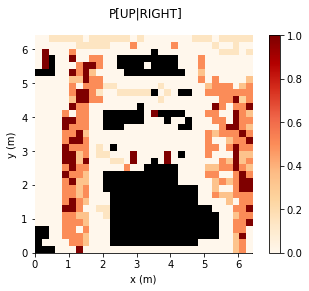

In [103]:
last_vx, last_vy, next_vx, next_vy = np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2)
show_occ(patch, patch_probs, last_vx, last_vy, next_vx, next_vy)

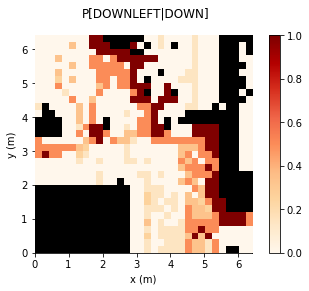

In [18]:
# new
last_vx, last_vy, next_vx, next_vy = np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2)
show_occ(patch, patch_probs, last_vx, last_vy, next_vx, next_vy)

## crop a patch

In [10]:
patch_size = 32
x, y = np.random.randint(0, width-patch_size), np.random.randint(0, height-patch_size)

In [11]:
patch = map_[slice(x, x+patch_size), slice(y, y+patch_size)]
patch_probs = probs[slice(x, x+patch_size), slice(y, y+patch_size)]

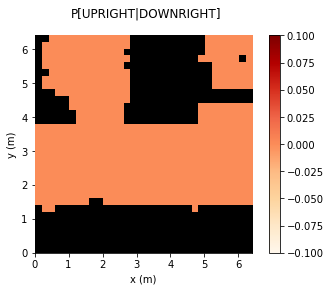

In [107]:
last_vx, last_vy, next_vx, next_vy = np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2), np.random.randint(-1,2)
fig = plt.figure()
show_map(patch, resolution=0.2)
occ_map_axes, _ = plot_occ_map(patch_probs[:,:,last_vx,last_vy,next_vx,next_vy], patch, occ_map_res=0.2)
last_mv  = vel_to_word([last_vx, last_vy])
next_mv = vel_to_word([next_vx, next_vy])
fig.suptitle('P[{}|{}]'.format(next_mv, last_mv))
c_bar = plt.colorbar(occ_map_axes, orientation='vertical')
plt.show()

## augmentation

In [19]:
def flatten_fn(diagnoal):
    """ Flatten matrix of dimension [width, height, num_x_velocities, num_y_velocities,
     num_x_velocities, num_y_velocities] to [width, height, num_movements, num_movements]. """
    if diagnoal:
        velocities = [[0, 1], [1, 0], [0, -1], [-1, 0],
                      [1, 1], [1, -1], [-1, 1], [-1, -1]]
    else:
        velocities = [[0, 1], [1, 0], [0, -1], [-1, 0]]

    def flatten(transition_probs):
        width, height = transition_probs.shape[0], transition_probs.shape[1]
        num_vel = len(velocities)
        res = np.zeros((width, height, num_vel, num_vel), dtype=transition_probs.dtype)
        for i, vel_x in enumerate(velocities):
            for j, vel_y in enumerate(velocities):
                idx_ls_mv = Grid_HMM.two_d_vel_to_idx(vel_x)
                idx_nx_mv = Grid_HMM.two_d_vel_to_idx(vel_y)
                res[:, :, i, j] = transition_probs[:, :,
                                  idx_ls_mv[0], idx_ls_mv[1],
                                  idx_nx_mv[0], idx_nx_mv[1]]
        return res

    return flatten

In [30]:
def flip(probs):
    # spatial dimensions of numpy array flip updown
    probs = np.flip(probs, axis=0)
    # velocity directions of left/right change to right/left
    probs = np.flip(probs, axis=3)
    probs = np.flip(probs, axis=5)
    return probs


def flip_masks(masks):
    # spatial dimensions of numpy array flip updown
    masks = np.flip(masks, axis=0)
    # velocity directions of left/right change to right/left
    masks = np.flip(masks, axis=3)
    return masks


def rotate(probs, k):
    """ Rotate the probs 90 degrees counter-clockwise k times.

    Note that directions of probabilities change after rotations. For example, if rotate once,
    the probability of P{left|down} changes to P{down|right}.
    """
    if k == 0:
        return probs

    # spatial dimensions rotate counter-clockwise
    probs = np.rot90(probs, k=k)
    # velocitiy dimensions rotate clockwise
    probs = np.rot90(probs, k, (2, 3))
    probs = np.rot90(probs, k, (4, 5))
    return probs


def rotate_masks(masks, k):
    """ Rotate the masks 90 degrees counter-clockwise k times.

    """
    if k == 0:
        return masks

    masks = np.rot90(masks, k=k)
    masks = np.rot90(masks, k, (2, 3))
    return masks

In [21]:
def augment(input, output, diagonal=True):
    
    flatten = flatten_fn(diagonal)
        
    def augment_name(mirror, num_rot):
        m = 'mirrored' if mirror else 'n/mirrored'
        return m + ' {} rot'.format(num_rot)
    inputs, outputs = {}, {}
    
    # augment that segment 8 times
    for mirror in [False, True]:
        input_ = input
        output_ = output
        if mirror:
            # flip left/right visually means
            # filp up/down the numpy array
            input_ = np.flipud(input)
            output_ = flip(output)
        for num_rot in range(4):
            input__ = np.rot90(input_, k=num_rot)
            output__ = rotate(output_, k=num_rot)
            name = augment_name(mirror, num_rot)
            inputs[name] = input__.copy()
            outputs[name] = flatten(output__).copy()

    return inputs, outputs


In [31]:
inputs, outputs = augment(patch, patch_probs)

## check augmentation results

In [23]:
inputs.keys()

['mirrored 1 rot',
 'mirrored 0 rot',
 'mirrored 3 rot',
 'n/mirrored 0 rot',
 'n/mirrored 2 rot',
 'mirrored 2 rot',
 'n/mirrored 3 rot',
 'n/mirrored 1 rot']

In [35]:
input, output = patch, patch_probs

#### mirrored 0 rot

In [36]:
augment_name = 'mirrored 0 rot'
a_input, a_output = inputs[augment_name], outputs[augment_name]

In [133]:
a_output.shape

(32, 32, 8, 8)

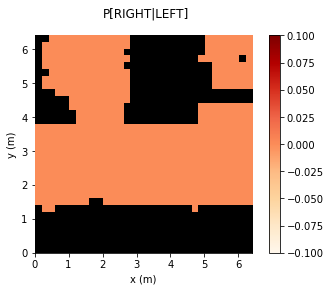

In [134]:
# before augmentation: p{right|left} 
vel = [-1, 0, 1, 0]
show_occ(input, output, *vel)

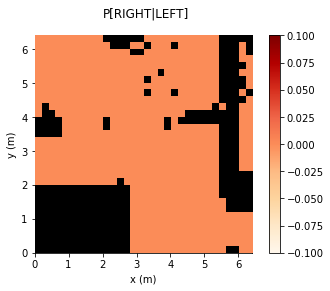

In [26]:
# new
# before augmentation: p{right|left} 
vel = [-1, 0, 1, 0]
show_occ(input, output, *vel)

4


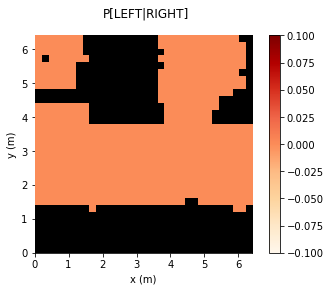

In [135]:
# after augmentation: p{left|right} 
vel = [1, 0, -1, 0]
show_occ(a_input, a_output, *vel)

4


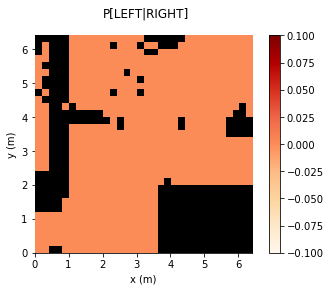

In [27]:
# new
# after augmentation: p{left|right} 
vel = [1, 0, -1, 0]
show_occ(a_input, a_output, *vel)

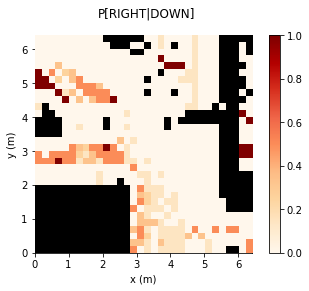

In [37]:
# before augmentation: p{right|down} 
vel = [0, -1, 1, 0]
show_occ(input, output, *vel)

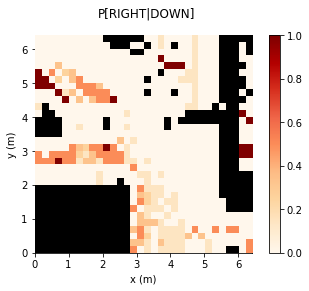

In [32]:
# new
# before augmentation: p{right|down} 
vel = [0, -1, 1, 0]
show_occ(input, output, *vel)

4


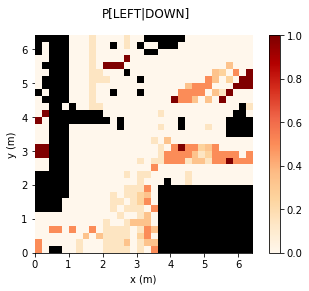

In [38]:
# after augmentation: p{left|down} 
vel = [0, -1, -1, 0]
show_occ(a_input, a_output, *vel)

4


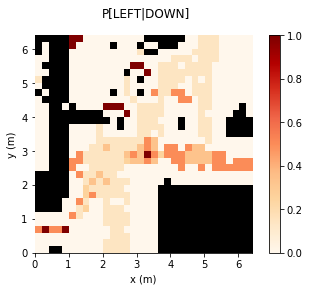

In [33]:
# new
# after augmentation: p{left|down} 
vel = [0, -1, -1, 0]
show_occ(a_input, a_output, *vel)

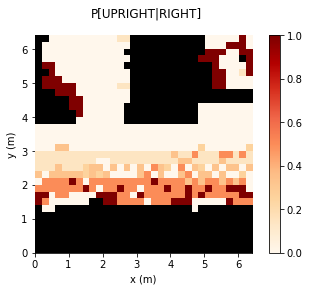

In [141]:
# before augmentation: p{upright|right} 
vel = [1, 0, 1, 1]
show_occ(input, output, *vel)

4


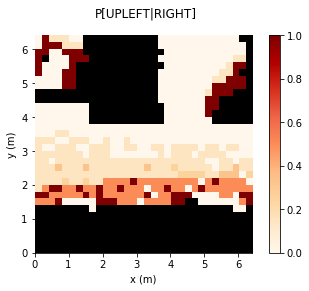

In [142]:
# after augmentation: p{upleft|right} 
vel = [1, 0, -1, 1]
show_occ(a_input, a_output, *vel)

#### n/mirrored 1 rot

In [149]:
augment_name = 'n/mirrored 1 rot'
a_input, a_output = inputs[augment_name], outputs[augment_name]

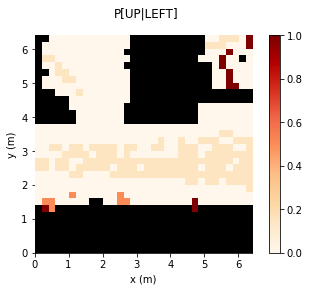

4


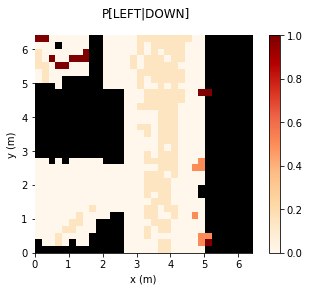

In [150]:
# before augmentation: p{up|left} 
vel = [-1, 0, 0, 1]
show_occ(input, output, *vel)
# after augmentation: p{left|down} 
vel = [0, -1, -1, 0]
show_occ(a_input, a_output, *vel)

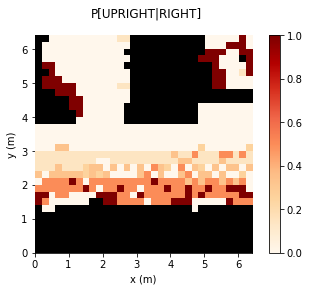

4


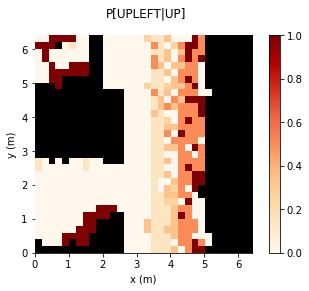

In [151]:
# before augmentation: p{upright|right} 
vel = [1, 0, 1, 1]
show_occ(input, output, *vel)
# after augmentation: p{upleft|up} 
vel = [0, 1, -1, 1]
show_occ(a_input, a_output, *vel)

#### mirrored 1 rot

In [152]:
augment_name = 'mirrored 1 rot'
a_input, a_output = inputs[augment_name], outputs[augment_name]

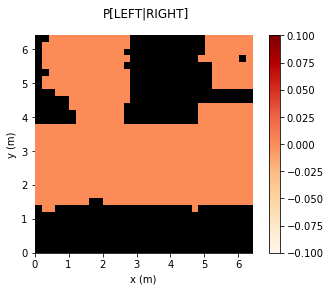

4


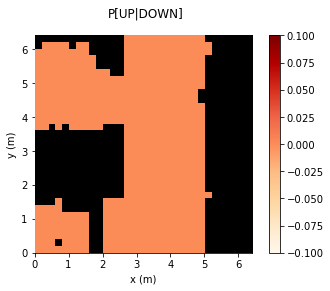

In [153]:
# before augmentation: p{left|right} 
vel = [1, 0, -1, 0]
show_occ(input, output, *vel)
# after augmentation: p{up|down} 
vel = [0, -1, 0, 1]
show_occ(a_input, a_output, *vel)

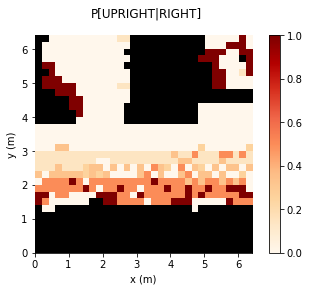

4


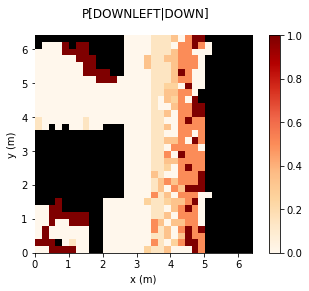

In [155]:
# before augmentation: p{upright|right} 
vel = [1, 0, 1, 1]
show_occ(input, output, *vel)
# after augmentation: p{upleft|left}->p{downleft|down} 
vel = [0, -1, -1, -1]
show_occ(a_input, a_output, *vel)